# Cluster similar regions on a hexgrid

In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import libpysal
import spopt
import h3
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance
from clustergram import Clustergram
from bokeh.io import output_notebook
from bokeh.plotting import show
from sklearn import cluster
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

import preprocess_data

Retrieve building dataset and levels of clusters

In [2]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

Show area of interest (Central Europe sans Hungary)

<Axes: >

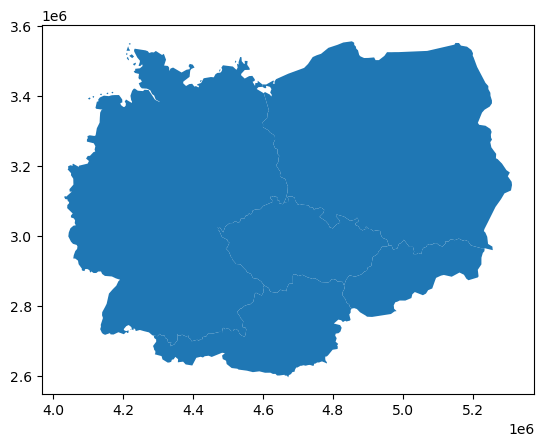

In [3]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi.plot()

Hexify AOI

In [4]:
hexed = h3fy(aoi, resolution=3)

/home/danka/work/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'aoi_hexed')

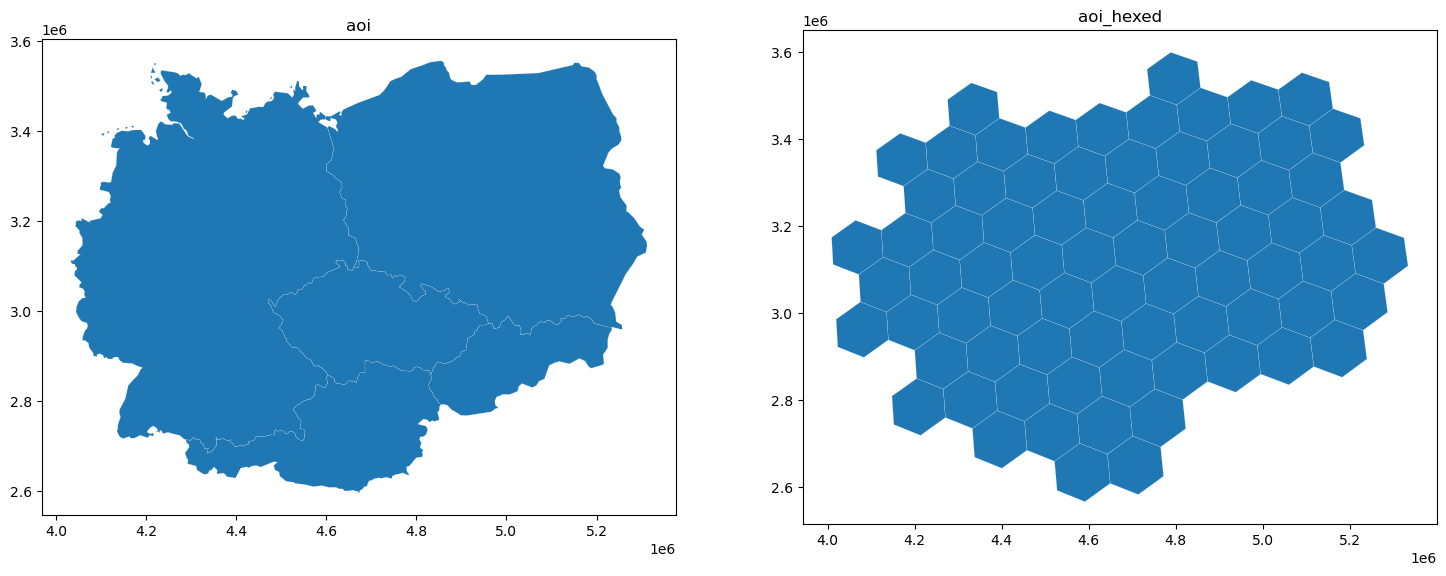

In [5]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

aoi.plot(ax=axs[0], linewidth=0.1, edgecolor='white')
hexed.plot(ax=axs[1], linewidth=0.1, edgecolor='white')

axs[0].set_title('aoi')
axs[1].set_title('aoi_hexed')

In [6]:
hexed

geometry
hex_id                                                            
831f52fffffffff  POLYGON ((4948900.827 3247639.141, 5012283.856...
831fabfffffffff  POLYGON ((4322580.144 2865573.857, 4384564.554...
831f88fffffffff  POLYGON ((4400275.867 2642932.21, 4457929.792 ...
831e2afffffffff  POLYGON ((5108691.228 2942641.52, 5165268.677 ...
831f55fffffffff  POLYGON ((5152245.191 3530387.501, 5089637.06 ...
...                                                            ...
831f8cfffffffff  POLYGON ((4270425.806 2759403.495, 4332499.017...
831f13fffffffff  POLYGON ((4238285.619 3207119.268, 4242747.672...
831e31fffffffff  POLYGON ((4801848.552 2932456.398, 4794938.941...
831f03fffffffff  POLYGON ((4569841.748 3443276.96, 4509240.905 ...
831e21fffffffff  POLYGON ((4948900.827 3247639.141, 4893187.384...

[75 rows x 1 columns]

In [7]:
hexed.index.name = "NAME"

Join buildings dataset with the hexgrid on a specified hierarchy level

In [8]:
# def join_buildings_with_grid(level):
#     joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
#     data = joined.groupby("NAME")[level].value_counts().unstack().fillna(0)
#     data_norm = preprocess_data.normalize_building_counts(data)

#     return data_norm.T

In [9]:
joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
data = joined.groupby("NAME")["level_4"].value_counts().unstack().fillna(0)
X = data.values / data.sum(axis=1).values[:, np.newaxis]
X

array([[3.96184493e-02, 2.14243011e-02, 9.35316635e-02, 6.71441503e-02,
        2.19354941e-01, 6.02704088e-03, 5.16291055e-01, 3.66083990e-02],
       [4.32877494e-02, 1.57001276e-02, 1.31440397e-01, 9.62096681e-02,
        1.92801135e-01, 8.97940250e-03, 4.84081320e-01, 2.75002007e-02],
       [6.91721024e-02, 3.02042864e-02, 3.75915705e-02, 2.34933697e-01,
        2.90462332e-01, 1.42756792e-02, 1.32095190e-01, 1.91265142e-01],
       [4.07147982e-02, 2.05942986e-02, 6.24566314e-02, 4.09432130e-01,
        2.64281598e-01, 2.87135683e-03, 1.68764040e-01, 3.08851474e-02],
       [4.19289092e-02, 2.64402334e-02, 4.30371578e-02, 6.15526408e-02,
        2.34411582e-01, 6.56227481e-02, 3.09083824e-01, 2.17922905e-01],
       [3.47534775e-02, 1.65762022e-02, 1.56602700e-01, 6.59102939e-02,
        2.51922438e-01, 4.22624116e-03, 4.56463634e-01, 1.35450125e-02],
       [3.66667411e-02, 1.69177323e-02, 6.69880307e-02, 4.56722236e-01,
        2.58973272e-01, 1.45164290e-02, 1.27757073e-01, 2.

In [10]:
data

level_4               1       2      3       4       5       6        7  \
NAME                                                                      
831e00fffffffff   39960   21609  94338   67723  221246    6079   520742   
831e01fffffffff   24263    8800  73673   53926  108066    5033   271330   
831e04fffffffff   48251   21069  26222  163878  202612    9958    92143   
831e05fffffffff   48466   24515  74347  487379  314595    3418   200893   
831e06fffffffff   40671   25647  41746   59706  227379   63654   299811   
...                 ...     ...    ...     ...     ...     ...      ...   
831faafffffffff   95739   91154  27819   61968  166519   33315  1714770   
831fabfffffffff   52569   64410  62201   52363  236830   25389  1019419   
831facfffffffff   38276   47670  19107   29073  148825   15600  1013657   
831fadfffffffff   40281   38719  44810   33838  199947   56204   733632   
831faefffffffff  119653  103572  37692   31599  137159  102226  1781117   

level_4               8  
NAME                     
831e00fffffffff   36924  
831e01fffffffff   15414  
831e04fffffffff  133417  
831e05fffffffff   36765  
831e06fffffffff  211385  
...                 ...  
831faafffffffff  304077  
831fabfffffffff  162483  
831facfffffffff  164733  
831fadfffffffff  228800  
831faefffffffff  688702  

[75 rows x 8 columns]

Build a contiguity graph and perform an example agglomerative clustering using Bray–Curtis distance

In [11]:
%%time
queen = graph.Graph.build_contiguity(hexed)
agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete')
agg.fit(X)

CPU times: user 7.2 ms, sys: 0 ns, total: 7.2 ms
Wall time: 10.6 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 376 stored elements and shape (75, 75)>,
                        linkage='complete',
                        metric=<function braycurtis at 0x7f807e0ac540>,
                        n_clusters=6)

In [12]:
hexed[['geometry']].explore(agg.labels_, categorical=True, tiles="CartoDB Positron")

Try different numbers of clusters and create a clustergram

In [13]:
clusters = range(1,17)
labels_dict = {}

for k in clusters:
    labels_dict[k] = cluster.AgglomerativeClustering(n_clusters=k, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete').fit_predict(X)
labels = pd.DataFrame(labels_dict)
labels

1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0    0   1   1   3   3   3   3   3   3   3   3   3   3   3   1   1
1    0   0   0   0   1   1   1   0   0   0   4   4   4   4   4   4
2    0   0   0   0   1   1   1   0   8   8   8   8   8   8   8   8
3    0   0   0   0   1   1   1   0   0   4  10  10  10  10  10  10
4    0   1   1   3   3   3   3   3   3   3   3   3   3   3   1   1
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
70   0   0   0   0   1   1   1   0   0   0   4   4   4   4   4   4
71   0   0   0   1   0   0   0   7   7   7   7   7   7   7   7   7
72   0   0   0   0   4   4   4   4   4   9   9   9   9   9   9   9
73   0   0   0   1   0   0   2   2   2   2   2   2   5   5   5   5
74   0   1   1   3   3   3   3   3   3   3   3   3   3   3   1   1

[75 rows x 16 columns]

<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

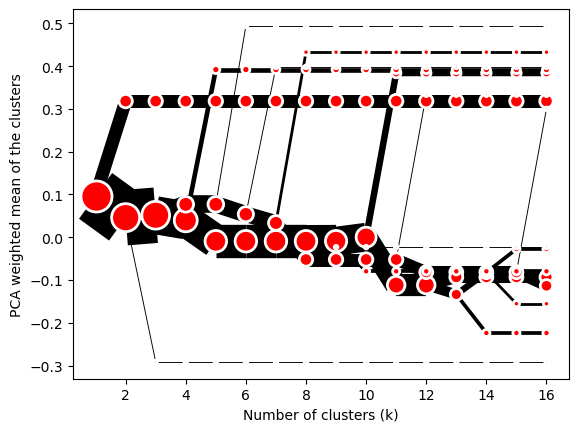

In [14]:
cgram = Clustergram.from_data(X, labels)
cgram.plot()

In [15]:
output_notebook()

Loading BokehJS ...

In [16]:
fig = cgram.bokeh()
show(fig)

Plot clusterized hexagons

In [17]:
def plot_cluster_maps(show_borders=False):
    fig, axs = plt.subplots(figsize=(15,10), nrows=4, ncols=4)
    axs = axs.flatten()
    
    for cluster, ax in zip(labels, axs):
        if show_borders:
            aoi.boundary.plot(ax=ax, color="maroon")
        hexed[["geometry"]].plot(labels[cluster].to_numpy(), ax=ax, categorical=True, cmap='tab20')
        ax.set_title(f"Number of clusters: {cluster}")
    
    plt.tight_layout()

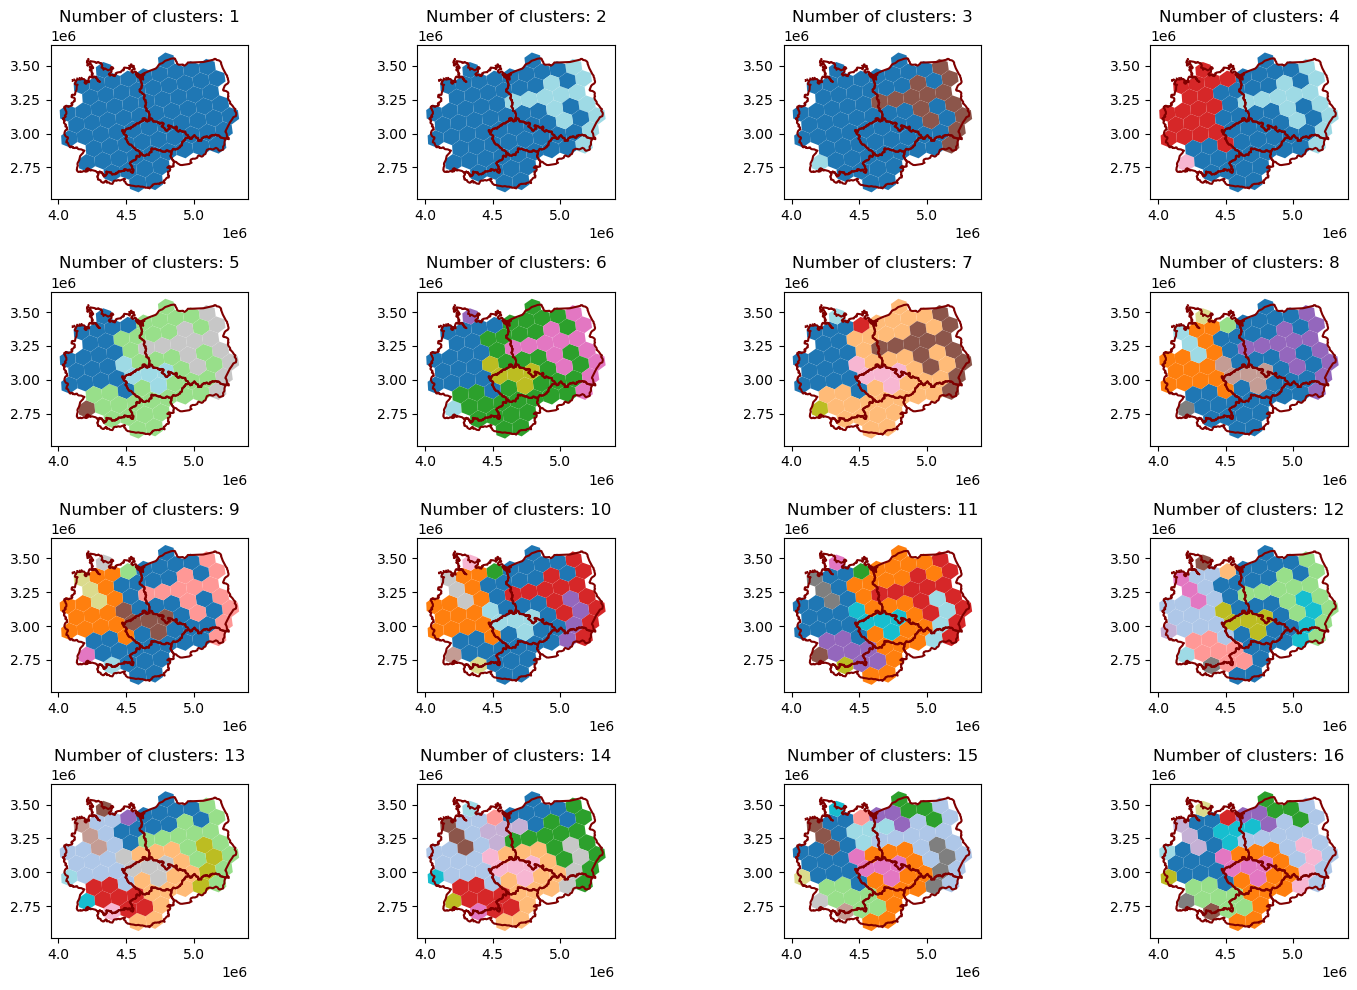

In [18]:
plot_cluster_maps(show_borders=True)

# Triangulation & Voronoi

Retrieve FUAs

In [19]:
fuas = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas

eFUA_ID  UC_num UC_IDs   eFUA_name  Commuting Cntry_ISO   Cntry_name  \
0         1.0     1.0   5959       Herat        1.0       AFG  Afghanistan   
1       192.0     1.0   5964     Guzarah        1.0       AFG  Afghanistan   
2       354.0     1.0   5968    Shindand        0.0       AFG  Afghanistan   
3       505.0     1.0   5970  Qala i Naw        0.0       AFG  Afghanistan   
4       648.0     1.0   5973       Farah        1.0       AFG  Afghanistan   
...       ...     ...    ...         ...        ...       ...          ...   
9026   1739.0     1.0   4191    Triangle        0.0       ZWE     Zimbabwe   
9027   1908.0     1.0   4206   Glenclova        0.0       ZWE     Zimbabwe   
9028   2062.0     1.0   4222     Bindura        1.0       ZWE     Zimbabwe   
9029   2137.0     1.0   4236   Marondera        1.0       ZWE     Zimbabwe   
9030   2211.0     1.0   4329      Mutare        1.0       ZWE     Zimbabwe   

      FUA_area  UC_area     FUA_p_2015      UC_p_2015    Com_p_2015  \
0        139.0     60.0  888811.175807  844574.564331  44236.611476   
1         32.0     16.0  169489.573231  160204.260864   9285.312366   
2         12.0     12.0  147553.403870  147553.403870      0.000000   
3          3.0      3.0   79809.722656   79809.722656      0.000000   
4         32.0     16.0  131508.797060  122843.460327   8665.336733   
...        ...      ...            ...            ...           ...   
9026       5.0      5.0   61859.251465   61859.251465      0.000000   
9027       4.0      4.0  158476.038086  158476.038086      0.000000   
9028      54.0     16.0  109737.644325   74992.162598  34745.481728   
9029      23.0     12.0   61332.544647   52538.743042   8793.801605   
9030      70.0     30.0  176620.319862  159616.356934  17003.962929   

                                               geometry  
0     MULTIPOLYGON (((5529000 4155000, 5531000 41550...  
1     MULTIPOLYGON (((5541000 4139000, 5542000 41390...  
2     MULTIPOLYGON (((5573000 4030000, 5574000 40300...  
3     MULTIPOLYGON (((5592000 4221000, 5590000 42210...  
4     MULTIPOLYGON (((5607000 3923000, 5608000 39230...  
...                                                 ...  
9026  MULTIPOLYGON (((3023000 -2577000, 3021000 -257...  
9027  MULTIPOLYGON (((3033000 -2449000, 3032000 -244...  
9028  MULTIPOLYGON (((3053000 -2126000, 3054000 -212...  
9029  MULTIPOLYGON (((3067000 -2235000, 3065000 -223...  
9030  MULTIPOLYGON (((3161000 -2326000, 3162000 -232...  

[9031 rows x 13 columns]

In [20]:
target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']

In [21]:
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)
fuas.explore()

In [22]:
triangulation = graph.Graph.build_triangulation(fuas.centroid, method="gabriel")

In [23]:
triangulation.explore(fuas.centroid)

Code from `05_cities.ipynb`

In [24]:
%%time
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
results = []

for region_id in regions.index:
    
    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_v10.pq')
    
    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 1min 53s, sys: 11.9 s, total: 2min 5s
Wall time: 1min 55s


In [44]:
level = 4
subset = all_fua_buildings[['country', 'city', 'final_without_noise']]
    
if level < 7:
    subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())


res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
res = res.unstack(-1).fillna(0).astype(int)

# normalise based on counts
# note: normalisation can be based on building area too
X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [45]:
X

array([[0.04980915, 0.02580337, 0.02183274, ..., 0.03591765, 0.17564039,
        0.0218555 ],
       [0.08344549, 0.03961978, 0.01509085, ..., 0.03995626, 0.25661171,
        0.09286676],
       [0.07676722, 0.0194089 , 0.01269043, ..., 0.01893662, 0.27397928,
        0.03858927],
       ...,
       [0.05882009, 0.02474248, 0.03495552, ..., 0.01218834, 0.53437024,
        0.01490987],
       [0.04184417, 0.03340942, 0.0559794 , ..., 0.02527984, 0.60887663,
        0.04749582],
       [0.04828372, 0.03603894, 0.02418721, ..., 0.01143853, 0.58551186,
        0.0282688 ]], shape=(136, 8))

In [46]:
res

final_without_noise      1     2      3      4      5     6       7      8
country city                                                              
AUT     Graz          8756  4536   3838  58141  59488  6314   30876   3842
        Innsbruck     4960  2355    897  10020  18060  2375   15253   5520
        Klagenfurt    5039  1274    833  17153  19581  1243   17984   2533
        Linz         10450  6428    503  28454  40336  3844   40980   5994
        Salzburg      5670  2070    491  12834  26010  1580   18362   5645
...                    ...   ...    ...    ...    ...   ...     ...    ...
SVK     Bratislava   17737  7554   7924   5221  31524  5076  119884  13903
        Košice        6162  3026  11519   4346  21889  1356   51061   2744
        Prešov        4020  1691   2389   2641  19230   833   36521   1019
        Trnava        3428  2737   4586   1827  13502  2071   49881   3891
        Žilina        4791  3576   2400   4960  21461  1135   58098   2805

[136 rows x 8 columns]

In [173]:
%%time
agg = cluster.AgglomerativeClustering(n_clusters=9, connectivity=triangulation.sparse, metric=distance.braycurtis, linkage='average')
agg.fit(X)

CPU times: user 4.73 ms, sys: 31 μs, total: 4.76 ms
Wall time: 4.7 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 548 stored elements and shape (136, 136)>,
                        linkage='average',
                        metric=<function braycurtis at 0x7f807e0ac540>,
                        n_clusters=9)

In [174]:
fuas.explore(column=agg.labels_, categorical=True)

In [175]:
from spopt.region import SA3, AZP, MaxPHeuristic

In [176]:
df = pd.DataFrame(X, index=fuas.index)

In [177]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=20, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

In [178]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [179]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])
dissolved_fuas

geometry  eFUA_ID  UC_num  \
0  MULTIPOLYGON (((4957228.92 3133188.246, 495815...    140.0     2.0   
1  MULTIPOLYGON (((4658826.424 2634272.267, 46587...    199.0     1.0   
2  MULTIPOLYGON (((4105484.537 2924614.713, 41073...     44.0     2.0   
3  MULTIPOLYGON (((4141725.51 2735204.847, 414162...   2227.0     1.0   

      UC_IDs eFUA_name  Commuting Cntry_ISO Cntry_name  FUA_area  UC_area  \
0  2907;2914  Szczecin        1.0       POL     Poland     684.0     97.0   
1       2885  Salzburg        1.0       AUT    Austria     368.0     46.0   
2  2245;2235   Heerlen        1.0       DEU    Germany     532.0    111.0   
3       2392     Basel        1.0       DEU    Germany     266.0     31.0   

      FUA_p_2015      UC_p_2015     Com_p_2015  
0  486245.297774  325875.429302  160369.868472  
1  261062.845268  140052.170959  121010.674308  
2  544558.664806  293165.160751  251393.504054  
3  175618.474969   75296.017583  100322.457386

In [180]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)

/tmp/ipykernel_9500/777305694.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)


In [181]:
voronoi

geometry
0  POLYGON ((4632322.997 3322680.894, 4631528.149...
1  POLYGON ((4515629.662 2622061.758, 4516059.07 ...
2  POLYGON ((4085580.615 2823557.43, 4085115.572 ...
3  POLYGON ((4062020.047 2811033.152, 4082266.209...

<Axes: >

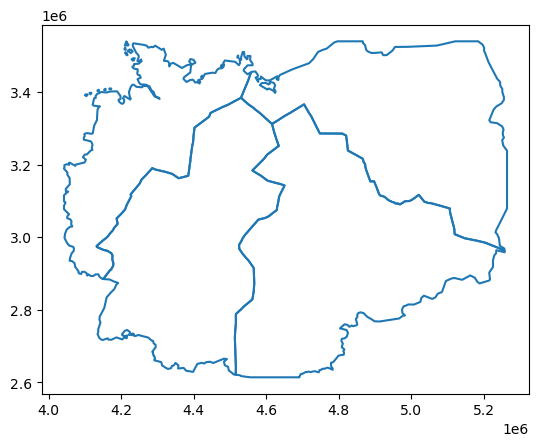

In [182]:
optimal_boundaries = gpd.clip(voronoi, aoi)
optimal_boundaries.boundary.plot()

In [183]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='eom', metric=distance.braycurtis, linkage='average')
clusterer.solve()

In [184]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [185]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [186]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_9500/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


<Axes: >

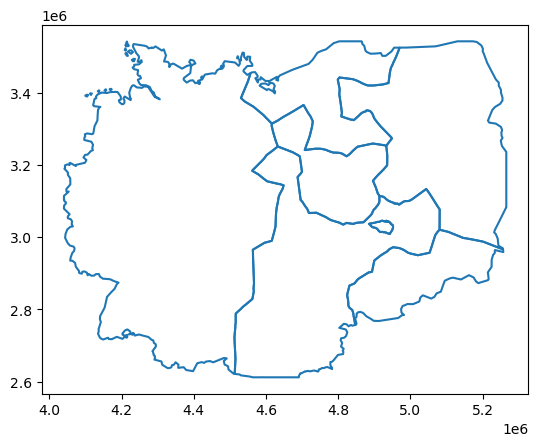

In [187]:
optimal_boundaries = gpd.clip(voronoi, aoi)
optimal_boundaries.boundary.plot()

In [155]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='leaf', metric=distance.braycurtis, linkage='average')
clusterer.solve()

In [156]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [157]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [158]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_9500/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


<Axes: >

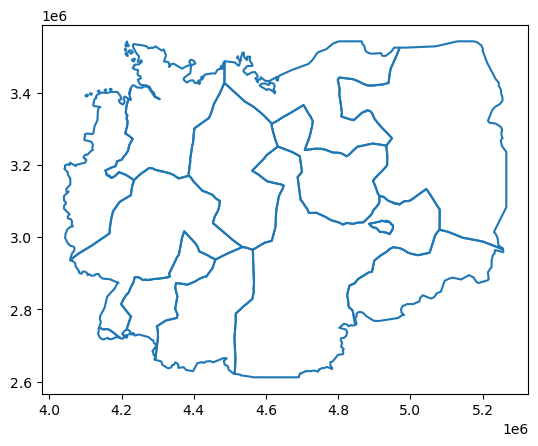

In [159]:
optimal_boundaries = gpd.clip(voronoi, aoi)
optimal_boundaries.boundary.plot()

In [194]:
AZP?

Init signature:
AZP(
    gdf,
    w,
    attrs_name,
    n_clusters=5,
    allow_move_strategy=None,
    random_state=None,
    initial_labels=None,
    objective_func=<spopt.region.objective_function.ObjectiveFunctionPairwise object at 0x7f80727f56d0>,
)
Docstring:     
AZP involves class offering the implementation of
the automatic zoning procedure algorithm.

Parameters
----------

gdf : geopandas.GeoDataFrame
    Geodataframe containing original data.

w : libpysal.weights.W
    Weights object created from given data.

attrs_name : list
    Strings for attribute names (cols of ``geopandas.GeoDataFrame``).

n_clusters : int
    The number of clusters to form. Default is ``5``.

allow_move_strategy : None or AllowMoveStrategy
    For a different behavior for allowing moves an AllowMoveStrategy
    instance can be passed as argument. Default is ``None``.

random_state : None, int, str, bytes, or bytearray
    Random seed. Default is ``None``.

initial_labels : numpy.ndarray or None
  

In [203]:
clusterer = AZP(df, triangulation.to_W(), attrs_name=df.columns, n_clusters=9)
clusterer.solve()

In [204]:
fuas.explore(column=clusterer.labels_, categorical=True)

In [189]:
MaxPHeuristic?

Init signature:
MaxPHeuristic(
    gdf,
    w,
    attrs_name,
    threshold_name,
    threshold,
    top_n=2,
    max_iterations_construction=99,
    max_iterations_sa=10,
    verbose=False,
    policy='single',
)
Docstring:     
The max-p-regions involves the aggregation of n areas into an
unknown maximum number of homogeneous regions, while ensuring that
each region is contiguious and satisfies a minimum threshold value
imposed on a predefined spatially extensive attribute.

Parameters
----------

gdf : geopandas.GeoDataFrame, required
    Geodataframe containing original data.

w : libpysal.weights.W, required
    Weights object created from given data.

attrs_name : list, required
    Strings for attribute names (cols of ``geopandas.GeoDataFrame``).

threshold_name : string, required
    The name of the spatial extensive attribute variable.

threshold : {int, float}, required
    The threshold value.

top_n : int, required
    The number of top candidate regions to consider for en

In [206]:
df

0         1         2         3         4         5         6  \
252   0.049809  0.025803  0.021833  0.330739  0.338402  0.035918  0.175640   
253   0.083445  0.039620  0.015091  0.168573  0.303836  0.039956  0.256612   
254   0.076767  0.019409  0.012690  0.261319  0.298309  0.018937  0.273979   
255   0.076283  0.046923  0.003672  0.207710  0.294447  0.028061  0.299148   
256   0.078033  0.028488  0.006757  0.176626  0.357959  0.021745  0.252704   
...        ...       ...       ...       ...       ...       ...       ...   
7673  0.084938  0.036174  0.037946  0.025002  0.150960  0.024308  0.574094   
7674  0.060351  0.029637  0.112817  0.042565  0.214382  0.013281  0.500093   
7675  0.058820  0.024742  0.034956  0.038643  0.281371  0.012188  0.534370   
7676  0.041844  0.033409  0.055979  0.022301  0.164813  0.025280  0.608877   
7677  0.048284  0.036039  0.024187  0.049987  0.216284  0.011439  0.585512   

             7  
252   0.021855  
253   0.092867  
254   0.038589  
255   0.043755  
256   0.077688  
...        ...  
7673  0.066578  
7674  0.026875  
7675  0.014910  
7676  0.047496  
7677  0.028269  

[136 rows x 8 columns]